## Isolation Forest

This is a demo to show my implementation of isolation forest based on [this paper](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)

> F. T. Liu, K. M. Ting and Z. Zhou, "Isolation Forest," 2008 Eighth IEEE International Conference on Data Mining, Pisa, 2008, pp. 413-422.

Isolation forests are used for anamoly detection and the idea is based on the observation that anomalies have distinctive quantitative properties:

1. they are the minority consisting of fewer instances
2. they have attribute-values that are very different from those of normal instances

In [1]:
import numpy as np
from isolation_forest import IsolationForest

### The Dataset

As an example we will use the `Mulcross` dataset for anomaly detection. The data is generated from a synthetic data generator. It can be downloaded from [OpenML](https://www.openml.org/d/40897). 

The dataset has four numnerical features V1, V2, V3 V4 and a target variable that is either "Normal" or "Anomaly". The "Anomaly" class represents only 10% of total samples. We will use this target variable to calculate the accuracy and AUC score of the isolation forest.

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd

Let's load the data into a Panda dataframe

In [3]:
data = pd.read_csv('mulcross.csv')
data

,V1,V2,V3,V4,Target
0,-0.203950,0.363011,1.013766,0.187131,'Normal'
1,-0.761118,2.436424,0.681846,0.654366,'Normal'
2,-0.209979,1.131098,-0.282180,-0.202210,'Normal'
3,0.836812,0.650342,-0.426900,-0.305281,'Normal'
4,0.454204,1.560128,-0.204841,0.219233,'Normal'
...,...,...,...,...,...
262139,-0.699533,-1.110000,-0.084369,-0.575921,'Normal'
262140,-1.972119,0.965250,-0.240917,0.463352,'Normal'
262141,-0.327949,-1.702591,-0.031113,-0.759623,'Normal'
262142,-2.080999,-0.185966,-0.518695,-0.829814,'Normal'


We can plot a histogram to see the distribution of classes

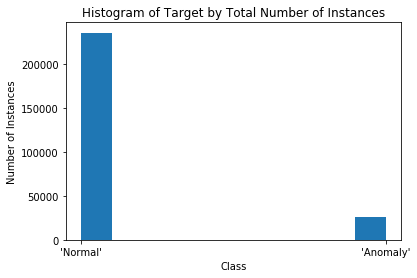

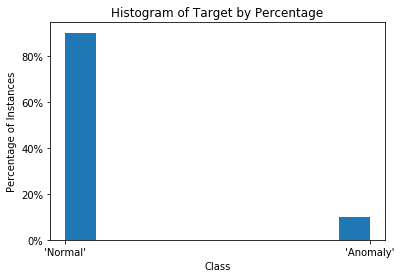

In [4]:
_ = plt.hist(data['Target'])
plt.title('Histogram of Target by Total Number of Instances')
plt.ylabel('Number of Instances')
plt.xlabel('Class')
plt.show()

plt.hist(data['Target'], weights=np.ones(len(data)) / len(data))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Histogram of Target by Percentage')
plt.ylabel('Percentage of Instances')
plt.xlabel('Class')
plt.show()

### Training Stage: Building the Isolation Forest

In [4]:
# convent dataframe to numpy array
X = data[['V1','V2','V3', 'V4']].values
y = data['Target'].values

print(X.shape)
print(y.shape)

(262144, 4)
(262144,)


build an isolation forest with 100 trees and a maximum subsampling size of 256

In [5]:
m = 100
sub_sampling_size = 256

In [6]:
isolation_forest = IsolationForest().fit(X, m=m, sub_sampling_size=sub_sampling_size)
len(isolation_forest)

100

### Evaluation Stage: Detection Anomalies

In order to detect anomalies, we calculate the average `Path Length` of each instance in the forest.
Simply we calculate the `Path Length` over every tree then take the average.
Later this value is converted to a score.

In [7]:
def c(n):
    return 2.0*(np.log(n-1)+0.5772156649)-(2*(n-1.0)/n)

`size` function returns the number of nodes in a tree

In [8]:
def size(node):
    if node is None:
        return 0
    else:
        return max(size(node.left), size(node.right)) + 1

`pathLength` function calculates the path length in a single tree

In [22]:
def pathLength(x, tree, size):
    #if tree is an external node then return c(T.size)
    if tree.cutoff_id is None:
        return  c(size)
    else:
        if x[tree.cutoff_id] < tree.cutoff_val:
            return pathLength(x, tree.left, size) + 1
        else:
            return pathLength(x, tree.right, size) + 1

`averagePathLength` function calculates the path length in the entire forest

In [12]:
def averagePathLength(x, forest):
    path_length = 0
    for i in range(m):
        curr_len = pathLength(x, forest[i], size(forest[i]))
        path_length += curr_len
    return  path_length /m

The average path length is converted into a score between [0,1]. According to the original paper

(a) if instances return s very close to 1, then they are definitely anomalies

(b) if instances have s much smaller than 0.5, then they are quite safe to be regarded as normal instances

(c) if all the instances return s $\approx$ 0.5, then the entire sample does not really have any distinct anomaly.

In [23]:
def score(value, n):
    """
    value: average path length
    n: number of training instances
    """
    
    return 2 ** (-value/c(n))

In [24]:
def predict(isolation_forest, xTr):
    n, _ = xTr.shape
    predictions = np.zeros(n)
    for i in range(n):
        avg_len = averagePathLength(xTr[i], isolation_forest)
        predictions[i] = score(avg_len, n)
    return predictions

### AUC Score

In [47]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit

In [81]:
y_binary = np.array([1 if y_i == "'Anomaly'" else 0for y_i in y])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.0, random_state=0)
_, test_index = next(sss.split(X, y))
len(test_index)

13108

In [82]:
predictions = predict(isolation_forest, X[test_index])
predictions

array([0.74463426, 0.74463426, 0.74463426, ..., 0.74463426, 0.74463426,
       0.74463426])

In [83]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_binary[test_index], predictions)
roc_auc = auc(fpr, tpr)

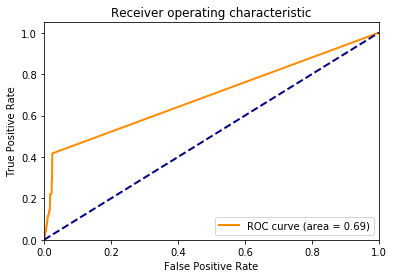

In [84]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()